In [1]:
import os
from pm4py.objects.log.importer.xes import factory as xes_importer

In [2]:
log = xes_importer.apply(os.path.join("files","input_data","sepsis.xes"), variant="iterparse")

In [3]:
from copy import deepcopy
from pm4py.objects.log.util import xes

# Based on sort_timestamp and sort_timestamp_trace from pm4py.objects.log.util.sorting
# https://github.com/pm4py/pm4py-source/blob/master/pm4py/objects/log/util/sorting.py#L82
def sorttrace(trace):
    new_trace = deepcopy(trace)
    new_trace._list.sort(key=lambda x: (x[xes.DEFAULT_TIMESTAMP_KEY], x['lifecycle:transition']=='start'))
    return new_trace
    
def sortlog(log):
    new_log = deepcopy(log)
    new_log._list = [x for x in new_log._list if len(x) > 0]
    for i in range(len(new_log._list)):
        new_log._list[i] = sorttrace(new_log._list[i])
    return new_log

log = sortlog(log)

In [4]:
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.objects.conversion.dfg import factory as dfg_mining_factory

dfg = dfg_factory.apply(log, variant="frequency") # variant = frequency or performance

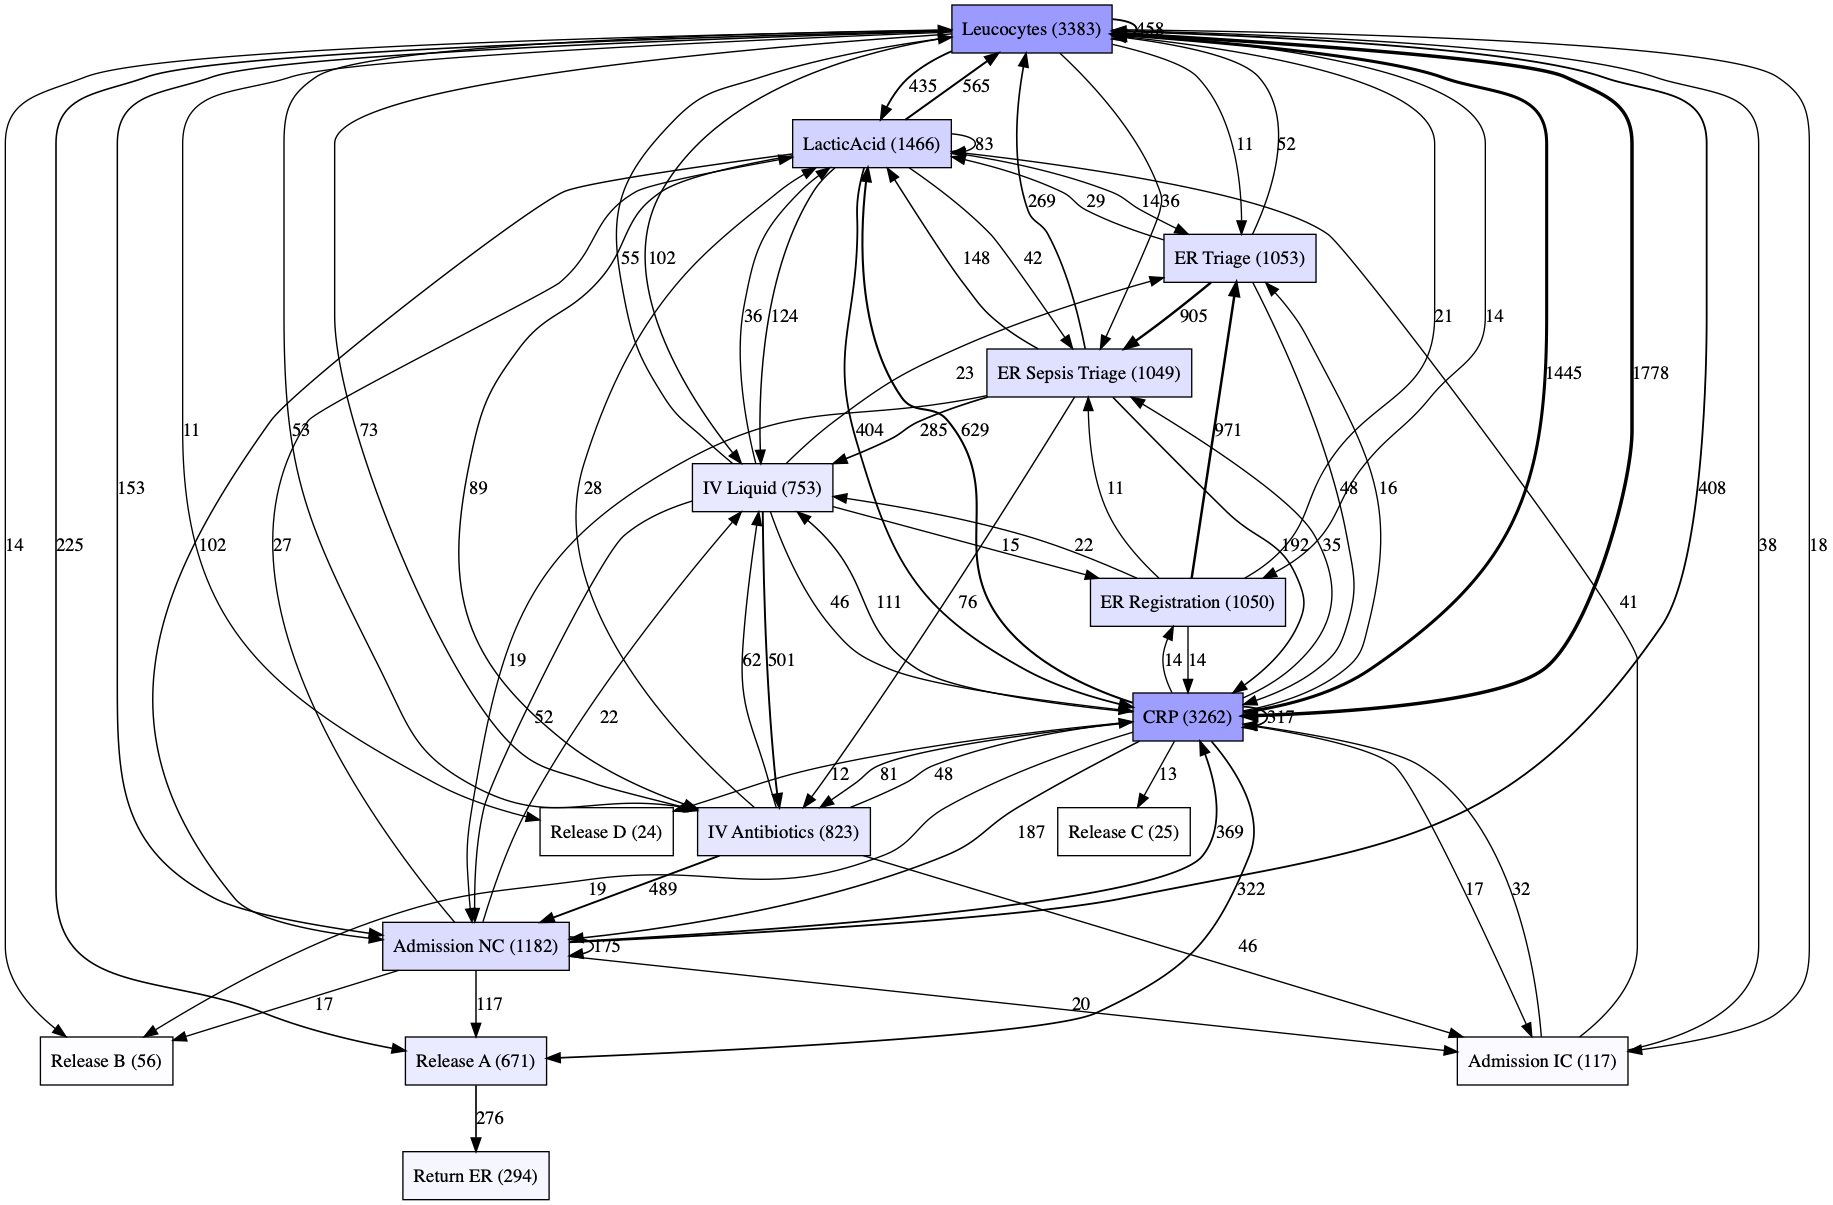

In [5]:
from pm4py.visualization.dfg import factory as dfg_vis_factory

gviz = dfg_vis_factory.apply(dfg, log=log, variant="frequency")
dfg_vis_factory.view(gviz)

In [38]:
from ntnu_process_mining import ProcessMap



process_map = ProcessMap()

def on_filter_change(change={}):
    print(f'Filter changed to {process_map.filter}')
    pm_edges = []
    #for (src, dst), weight in dfg.items():
    max_weight = dfg.most_common(1)[0][1]
    # for (src, dst), weight in dfg.most_common(process_map.filter):
    for (src, dst), weight in dfg.items():
        if max_weight*(process_map.filter/100) <= weight:
            pm_edges.append({"from": src, "to": dst, "value": weight})
    process_map.value=pm_edges

process_map.observe(on_filter_change, names='filter')

on_filter_change()
process_map

Filter changed to 1


ProcessMap(value=[{'from': 'ER Registration', 'to': 'Leucocytes', 'value': 21}, {'from': 'Leucocytes', 'to': '…

1778